In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
import tensorflow as tf
from tensorflow.python.framework import ops

In [2]:
d_t = 0.01
d_t_decimal = str(d_t)[::-1].find('.')
steps = 6000

In [3]:
class PID:
    def __init__(self, Kp=0, Ki=0, Kd=0):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
#         self.I_max = 20
        self.e = 0
        self.t = 0
        self.e_prev = 0
        self.t_prev = 0
        self.P = 0
        self.I = 0
        self.D = 0
        self.u = 0
        
    def set_state(self, e, t):
        self.e = e
        self.t = t
        
    def update(self, Kp=None, Ki=None, Kd=None):
        if Kp is not None and Ki is not None and Kd is not None:
            self.Kp = Kp
            self.Ki = Ki
            self.Kd = Kd
        
        delta_time = self.t - self.t_prev
        delta_error = self.e - self.e_prev
        
        self.P = self.e
        
        self.I += self.e * delta_time

#         if (self.I < -self.I_max):
#             self.I = -self.I_max
#         elif (self.I > self.I_max):
#             self.I = self.I_max

        if delta_time > 0:
            self.D = delta_error / delta_time
        else:
            self.D = 0

        self.t_prev = self.t
        self.e_prev = self.e

        self.u = self.Kp * self.P + self.Ki * self.I + self.Kd * self.D
        return np.float32(self.u)
        
    def d_update(self, Kp, Ki, Kd):
        return np.float32(self.P), np.float32(self.I), np.float32(self.D)
    
    def reset(self):
        self.e = 0
        self.t = 0
        self.e_prev = 0
        self.t_prev = 0
        self.P = 0
        self.I = 0
        self.D = 0
        self.u = 0
        
    def gain_from_FOPDT(self, K, tau, T):
        #658.PDF
        a1=1.086
        b1=-0.869
        a2=0.740
        b2=-0.130
        a3=0.348
        b3=0.914
        
        Kp = a1/K*(T/tau)**b1
        Ki = tau/(a2+b2*(T/tau))
        Kd = a3*tau*(T/tau)**b3
        
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd


In [4]:
def plant_process(y, t, u):
    K = 0.01
    tau = 1.0
    T = 0.2
    
    t_delay = round(t-T, d_t_decimal)
    if (t_delay<= 0) or (t_delay<0.0):
        u_delay = u[0]
    else:
        step_t = int(t_delay/d_t)-1
        if step_t >= steps:
            u_delay = u[-1]
        else: 
            u_delay = u[step_t]  
        
    dydt = (-y + K*u_delay)/tau
    return dydt

def plant(y_0, t1, t2, u):
    ts = [t1, t2]
    return odeint(plant_process, y_0, ts, args=(u,))[1]

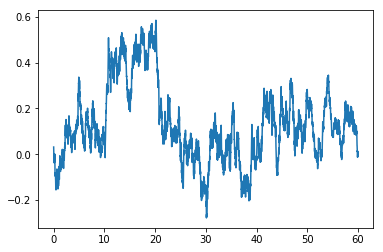

In [5]:
interval = 500
r_steps = steps//interval

r_sq = np.zeros(steps)
up = 0

for i in range(r_steps):
    if i < r_steps-1:
        r_sq[i * interval:(i+1)*interval] = up
    else:
        r_sq[i * interval:] = up
    if up > 0:
        up = -1
    else:
        up = 1

t = np.linspace(0, d_t*steps, steps)
r_sin = np.sin(t)

def gen_rand_sig(t):
    N = 1000
    x = np.random.normal(scale=10.0, size=len(t))
    return np.convolve(x, np.ones((N,))/N)[(N-1):] 
    
r_rand = gen_rand_sig(t)
plt.plot(t, r_rand)

r_combo = np.append(r_sin[:steps//2], r_sq[steps//2:])

### Plant control with neural network

In [6]:
pid = PID(1, 1, 1)
pid.gain_from_FOPDT(0.01, 1.0, 0.2)


r_delay = 5
u_delay = 5
y_p_delay = 5


graph = tf.Graph()
with graph.as_default():
    
    tf_r = tf.placeholder(tf.float32,shape=(r_delay, ), name="tf_r")
    tf_u = tf.placeholder(tf.float32,shape=(u_delay, ), name="tf_u")
    tf_y_p = tf.placeholder(tf.float32,shape=(y_p_delay, ), name="tf_y_p")
    tf_pid_vals = tf.placeholder(tf.float32,shape=(3, ), name="tf_pid_vals")
    
    tf_y_target = tf.placeholder(tf.float32,shape=(), name="tf_y_target")
    tf_lr = tf.placeholder(tf.float32, shape=(), name="tf_lr")

    def init_weights(layers, weights, biases):         
        for i in range(len(layers)):
            if i < len(layers) - 1:
                weights.append(tf.Variable(tf.truncated_normal([layers[i], layers[i+1]])))
                biases.append(tf.Variable(tf.zeros([layers[i+1]])))
            else:
                weights.append(tf.Variable(tf.truncated_normal([layers[i], 1])))
                biases.append(tf.Variable(tf.zeros([1])))
    # Model NN    
    #include input
    m_layers = [u_delay + y_p_delay + r_delay + 3, 20, 10, 5, 3]
    m_weights = []
    m_biases = []
    init_weights(m_layers, m_weights, m_biases)

    def forward_prop(input_value, layers, weights, biases):
        for i in range(len(layers)):  
            if i == 0:
                z = tf.matmul(input_value, weights[i]) + biases[i]
            else:
                z = tf.matmul(a, weights[i]) + biases[i]
            if i < len(layers) - 1:
                a = tf.nn.leaky_relu(z)
        return z
        
    
    # Forward prop model offline
    model_input = tf.concat([tf.reshape(tf_r, (1, r_delay)), tf.reshape(tf_u, (1, u_delay)), 
                            tf.reshape(tf_y_p, (1, y_p_delay)), tf.reshape(tf_pid_vals, (1, 3))], axis=1)
    
    y_model = forward_prop(model_input, m_layers, m_weights, m_biases)
    
    model_var_list = m_weights + m_biases
    model_loss = tf.losses.mean_squared_error(tf_y_target, tf.reshape(y_model, ()))
    model_opt = tf.train.AdamOptimizer(tf_lr).minimize(model_loss, var_list=model_var_list)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [7]:
epochs = 30

y_0 = 0
t_prev = 0
y_p = np.zeros(steps)
y_m = np.zeros(steps)
pid_vals = np.zeros(shape=(steps, 3))
u = np.zeros(steps)
r = r_sq
loss = []

def get_lr(epoch):
    return 0.01*np.e**(-0.1*epoch)

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()

    #Generate signal
    for i in range(steps):

        e = r[i] - y_0

        t_cur = t[i]
        pid.set_state(e, t_cur)
        u[i] = pid.update()
        pid_vals[i] = [pid.P, pid.I, pid.D]
        # Get plant output
        y_p[i] = plant(y_0, t_prev, t_cur, u)

        y_0 = y_p[i]
        t_prev = t[i]
        
    for j in range(epochs):
        print("Epoch", j)
        lr = get_lr(j)
        print("Lr:", lr)
        y_m = np.zeros(steps)
        epoch_loss = []
        for i in range(steps):
            #Get r_delay number of past r values (including current one)
            if i+1 >= r_delay:
                r_delayed = r[i+1-r_delay:i+1]
            else:
                continue
            #Get u_delay number of past u values (including current one)
            if i+1 >= u_delay:
                u_delayed = u[i+1-u_delay:i+1]
            else:
                continue
            #Get y_delay number of past y plant values (not including current y value)
            if i >= y_p_delay:
                y_p_delayed = y_p[i-y_p_delay:i]
            else:
                continue
            # Train model on plant output
            
            feed_dict = {tf_r:r_delayed, tf_u:u_delayed, tf_y_p:y_p_delayed, tf_pid_vals:pid_vals[i],
                         tf_y_target:y_p[i], tf_lr:lr}
            _, l, y_m[i] = session.run([model_opt, model_loss, y_model], feed_dict=feed_dict)
            loss.append(l)
            epoch_loss.append(l)
        print("Avg loss:", sum(epoch_loss)/len(epoch_loss))

    #Test
    y_m = np.zeros(steps)
    test_loss = []
    for i in range(steps):
        #Get r_delay number of past r values (including current one)
        if i+1 >= r_delay:
            r_delayed = r[i+1-r_delay:i+1]
        else:
            continue
        #Get u_delay number of past u values (including current one)
        if i+1 >= u_delay:
            u_delayed = u[i+1-u_delay:i+1]
        else:
            continue
        #Get y_delay number of past y plant values (not including current y value)
        if i >= y_p_delay:
            y_p_delayed = y_p[i-y_p_delay:i]
        else:
            continue

        feed_dict = {tf_r:r_delayed, tf_u:u_delayed, tf_y_p:y_p_delayed, tf_pid_vals:pid_vals[i], tf_y_target:y_p[i]}
        l, y_m[i] = session.run([model_loss, y_model], feed_dict=feed_dict)
        test_loss.append(l)

Epoch 0
Lr: 0.01
Avg loss: 17076.369742726067
Epoch 1
Lr: 0.009048374180359595
Avg loss: 1.475881876394105
Epoch 2
Lr: 0.008187307530779819
Avg loss: 6.899135483508709
Epoch 3
Lr: 0.007408182206817179
Avg loss: 1.326019597983313
Epoch 4
Lr: 0.006703200460356393
Avg loss: 1.0653046681525844
Epoch 5
Lr: 0.006065306597126334
Avg loss: 1.367065371875982
Epoch 6
Lr: 0.005488116360940264
Avg loss: 0.5450931799389196
Epoch 7
Lr: 0.004965853037914096
Avg loss: 0.5603851841928104
Epoch 8
Lr: 0.004493289641172216
Avg loss: 0.5486256555398201
Epoch 9
Lr: 0.004065696597405992
Avg loss: 0.3794621436214931
Epoch 10
Lr: 0.0036787944117144234
Avg loss: 0.27072216362217033
Epoch 11
Lr: 0.003328710836980796
Avg loss: 0.9929564412539783
Epoch 12
Lr: 0.003011942119122021
Avg loss: 0.22970775085696463
Epoch 13
Lr: 0.002725317930340126
Avg loss: 0.5515091160995795
Epoch 14
Lr: 0.0024659696394160645
Avg loss: 0.30535536872284086
Epoch 15
Lr: 0.0022313016014842983
Avg loss: 0.181822697089239
Epoch 16
Lr: 0.00

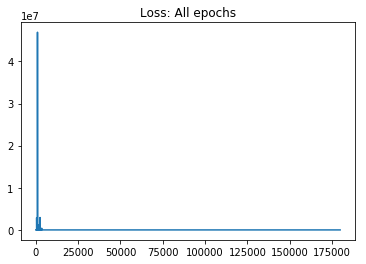

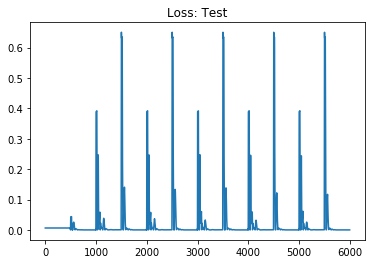

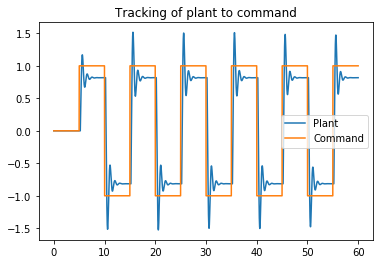

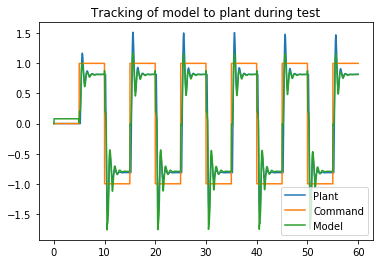

In [8]:
plt.plot(loss)
plt.title('Loss: All epochs')
plt.show()

plt.plot(test_loss)
plt.title('Loss: Test')
plt.show()

plt.plot(t, y_p)
plt.plot(t, r)
plt.title('Tracking of plant to command')
plt.legend(('Plant', 'Command'))
plt.show()

plt.plot(t, y_p)
plt.plot(t, r)
plt.plot(t, y_m)
# plt.ylim(top=3, bottom=-3)
plt.title('Tracking of model to plant during test')
plt.legend(('Plant', 'Command', 'Model'))
plt.show()